In [2]:
import pandas as pd
import numpy as np
import re
import datetime as dt #for working with times objects

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
from folium.plugins import HeatMap

In [4]:
#Reading in the cleansed data
chicago_set = pd.read_pickle("chicago_set.pkl")
chicago_set

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,duration
0,2018-04-01 00:04:44,2018-04-01 00:13:03,22,171,May St & Taylor St,May St & Cullerton St,3819,Subscriber,0 days 00:08:19
1,2018-04-01 00:06:42,2018-04-01 00:27:07,157,190,Lake Shore Dr & Wellington Ave,Southport Ave & Wrightwood Ave,5000,Subscriber,0 days 00:20:25
2,2018-04-01 00:07:19,2018-04-01 00:23:19,106,106,State St & Pearson St,State St & Pearson St,5165,Customer,0 days 00:16:00
3,2018-04-01 00:07:33,2018-04-01 00:14:47,241,171,Morgan St & Polk St,May St & Cullerton St,3851,Subscriber,0 days 00:07:14
4,2018-04-01 00:10:23,2018-04-01 00:22:12,228,219,Damen Ave & Melrose Ave,Damen Ave & Cortland St,5065,Subscriber,0 days 00:11:49
...,...,...,...,...,...,...,...,...,...
3584784,2018-03-31 23:46:34,2018-04-01 00:05:24,158,260,Milwaukee Ave & Wabansia Ave,Kedzie Ave & Milwaukee Ave,1935,Subscriber,0 days 00:18:50
3584785,2018-03-31 23:47:43,2018-03-31 23:52:05,299,229,Halsted St & Roscoe St,Southport Ave & Roscoe St,5852,Subscriber,0 days 00:04:22
3584786,2018-03-31 23:50:18,2018-03-31 23:57:38,327,226,Sheffield Ave & Webster Ave,Racine Ave & Belmont Ave,4414,Subscriber,0 days 00:07:20
3584787,2018-03-31 23:52:26,2018-04-01 00:07:13,265,426,Cottage Grove Ave & Oakwood Blvd,Ellis Ave & 60th St,6448,Subscriber,0 days 00:14:47


In [5]:
chicago_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3584782 entries, 0 to 3584788
Data columns (total 9 columns):
 #   Column              Dtype          
---  ------              -----          
 0   start_time          datetime64[ns] 
 1   end_time            datetime64[ns] 
 2   start_station_id    int64          
 3   end_station_id      int64          
 4   start_station_name  object         
 5   end_station_name    object         
 6   bike_id             int64          
 7   user_type           object         
 8   duration            timedelta64[ns]
dtypes: datetime64[ns](2), int64(3), object(3), timedelta64[ns](1)
memory usage: 273.5+ MB


In [7]:
# Get the fleet size and the number of stations
fleet_size = len(chicago_set["bike_id"].unique())
station_amount = len(chicago_set["start_station_id"].unique())

print("The Chicago fleet consists of {} bikes".format(fleet_size), "and there are {} stations, which were used in 2018.".format(station_amount))

The Chicago fleet consists of 6133 bikes and there are 621 stations, which were used in 2018.


In [10]:
# Amount of bike rentings grouped by date
day_demand = pd.DataFrame({'amount': chicago_set.groupby(chicago_set['start_time'].apply(lambda x: x.date())).size()})

day_demand.reset_index(inplace=True)
day_demand = day_demand.rename(columns = {'start_time':'date'})
day_demand['weekday'] = day_demand['date'].apply(lambda x: x.weekday())
day_demand["user types"] = chicago_set["user_type"]

day_demand

,date,amount,weekday,user types
0,2018-01-01,374,0,Subscriber
1,2018-01-02,1635,1,Subscriber
2,2018-01-03,2488,2,Customer
3,2018-01-04,2411,3,Subscriber
4,2018-01-05,2221,4,Subscriber
...,...,...,...,...
360,2018-12-27,2326,3,Subscriber
361,2018-12-28,3203,4,Subscriber
362,2018-12-29,1338,5,Customer
363,2018-12-30,1575,6,Subscriber


## Demand over the year

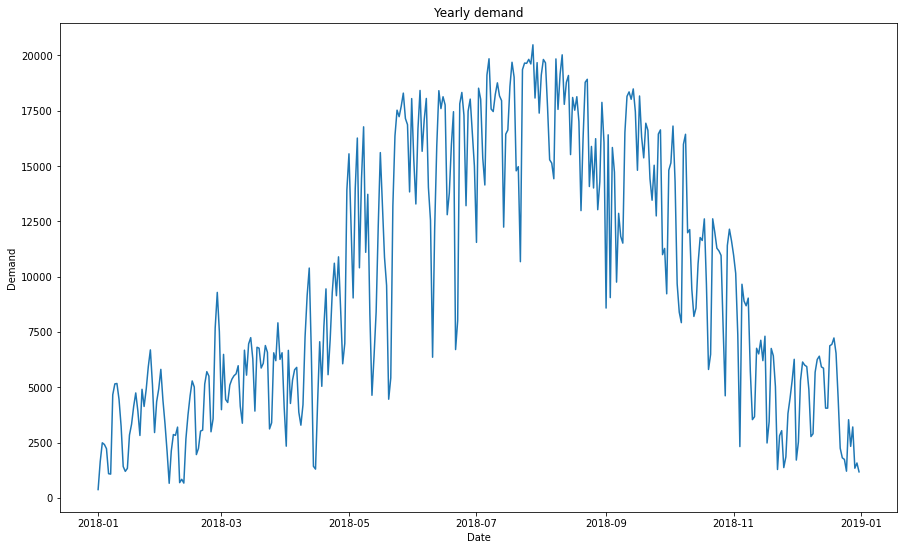

In [11]:
# Getting the demand over the year
fig, ax = plt.subplots(figsize = (15,9))

# Plotting the data
ax.plot(day_demand["date"],day_demand[["amount"]])
ax.set_xlabel("Date")
ax.set_ylabel("Demand")
ax.set_title("Yearly demand")

plt.show()

In [12]:
#search for max demand 
day_demand.iloc[day_demand['amount'].argmax()]

date          2018-07-28
amount             20471
weekday                5
user types      Customer
Name: 208, dtype: object

In [13]:
#search for min demand 
day_demand.iloc[day_demand['amount'].argmin()]

date          2018-01-01
amount               374
weekday                0
user types    Subscriber
Name: 0, dtype: object

## Demand over the months 

In [15]:
# Getting the monthly demand
month_demand = pd.DataFrame({'amount': chicago_set.groupby(by=[chicago_set['start_time'].apply(lambda x: x.date()),
                                                        chicago_set['start_time'].apply(lambda x: x.month)]).size()})


month_demand.reset_index(level=0, inplace=True)

month_demand = month_demand.rename(columns = {'start_time':'date'})

month_demand.reset_index(inplace=True)

month_demand = month_demand.rename(columns = {'start_time':'month'})

month_demand["user types"] = chicago_set["user_type"] 

month_demand

,month,date,amount,user types
0,1,2018-01-01,374,Subscriber
1,1,2018-01-02,1635,Subscriber
2,1,2018-01-03,2488,Customer
3,1,2018-01-04,2411,Subscriber
4,1,2018-01-05,2221,Subscriber
...,...,...,...,...
360,12,2018-12-27,2326,Subscriber
361,12,2018-12-28,3203,Subscriber
362,12,2018-12-29,1338,Customer
363,12,2018-12-30,1575,Subscriber


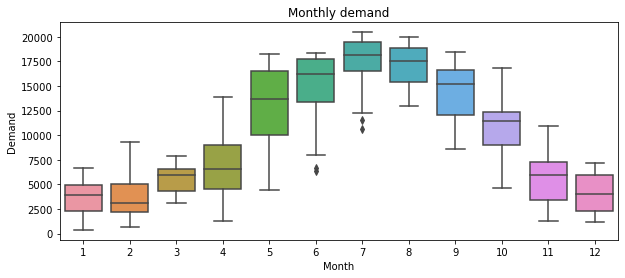

In [16]:
# Getting the monthly demand 
fig,ax = plt.subplots(figsize=(10,4))

sns.boxplot(x=month_demand["month"], y=month_demand["amount"], ax=ax)

ax.set_xlabel("Month")
ax.set_ylabel("Demand")
ax.set_title("Monthly demand")

plt.show()

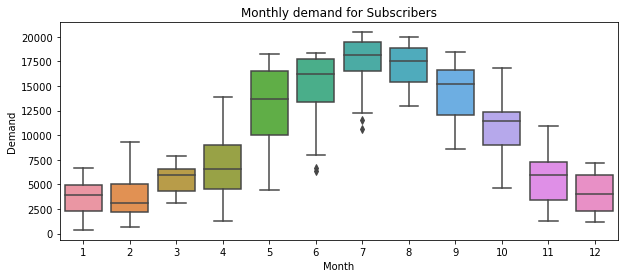

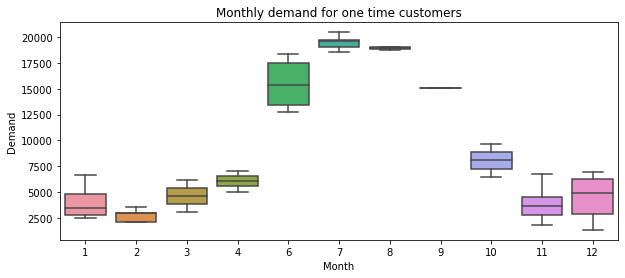

In [17]:
# Getting the different demands per user type to see if there are any differences

# Monthly demand of Monthly pass users

fig,ax = plt.subplots(figsize=(10,4))

month_demand_mp = month_demand[(month_demand["user types"] == "Subscriber")]

sns.boxplot(x=month_demand["month"], y=month_demand["amount"], ax=ax)

ax.set_xlabel("Month")
ax.set_ylabel("Demand")
ax.set_title("Monthly demand for Subscribers")

plt.show()

# Monthly demand of walk-up useres

fig,ax = plt.subplots(figsize=(10,4))

month_demand_wu = month_demand[(month_demand["user types"] == "Customer")]

sns.boxplot(x=month_demand_wu["month"], y=month_demand_wu["amount"], ax=ax)

ax.set_xlabel("Month")
ax.set_ylabel("Demand")
ax.set_title("Monthly demand for one time customers")

plt.show()

### Demand over the week

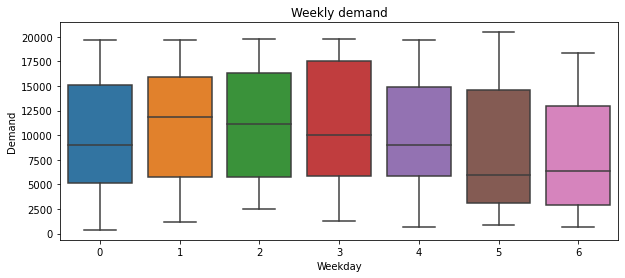

In [18]:
# Getting the demand over the week
fig,ax = plt.subplots(figsize=(10,4)) 

sns.boxplot(x=day_demand['weekday'], y=day_demand["amount"],ax=ax)

ax.set_xlabel("Weekday")
ax.set_ylabel("Demand")
ax.set_title("Weekly demand")

plt.show()

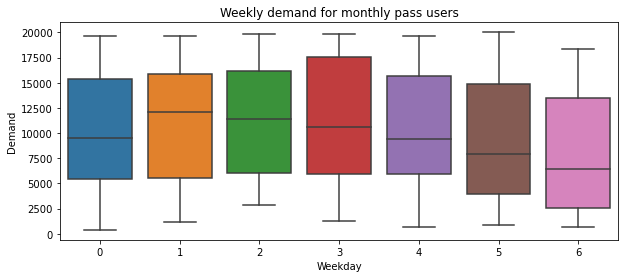

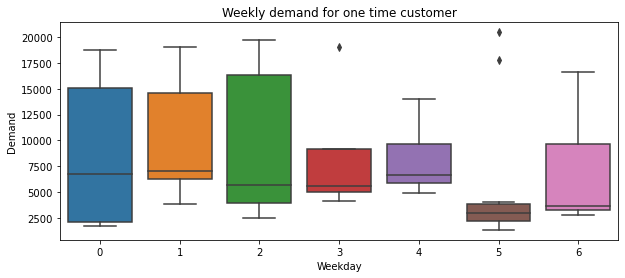

In [32]:
# Getting the different demands per user type, to see if there are any differences

# Demand per week of monthly pass users 

fig,ax = plt.subplots(figsize=(10,4)) 

day_demand_mp = day_demand[(day_demand["user types"] == "Subscriber")]


sns.boxplot(x=day_demand_mp['weekday'], y=day_demand_mp["amount"],ax=ax)

ax.set_xlabel("Weekday")
ax.set_ylabel("Demand")
ax.set_title("Weekly demand for monthly pass users")

plt.show()

# Demand per week of walk-up users users 

fig,ax = plt.subplots(figsize=(10,4)) 

day_demand_wu = day_demand[(day_demand["user types"] == "Customer")]


sns.boxplot(x=day_demand_wu['weekday'], y=day_demand_wu["amount"],ax=ax)

ax.set_xlabel("Weekday")
ax.set_ylabel("Demand")
ax.set_title("Weekly demand for one time customer")

plt.show()



# Geographical Patterns

In [24]:
# Geographical Demand Patterns:
# which stations are popular, which are not?

# Get popular start stations
popular_start_stations = chicago_set["start_station_id"].value_counts()
print("popular start stations:\n", popular_start_stations.head(5), "\n")

# Get popular end stations
popular_end_stations = chicago_set["end_station_id"].value_counts()
print("popular end stations:\n", popular_end_stations.head(5), "\n")

print("unpopular start stations:\n", popular_start_stations[-5:], "\n")

print("unpopular end stations:\n", popular_end_stations[-5:], "\n")
# -> count how many times station is mentioned (seperate start and stop?); maybe select routes that appear often

routes = chicago_set.groupby(['start_station_id', 'end_station_id']).size().sort_values(ascending=False)
print("popular routes: ")
routes.head(5)

popular start stations:
 35     66299
192    62540
77     51582
91     48578
43     37849
Name: start_station_id, dtype: int64 

popular end stations:
 35     77606
192    59072
77     49959
91     47546
43     37793
Name: end_station_id, dtype: int64 

unpopular start stations:
 608    2
648    2
653    1
651    1
363    1
Name: start_station_id, dtype: int64 

unpopular end stations:
 608    6
612    6
618    6
512    5
647    1
Name: end_station_id, dtype: int64 

popular routes: 


start_station_id  end_station_id
35                35                8249
76                35                7700
                  76                5542
43                192               4111
192               43                3981
dtype: int64

In [34]:
# loading dataset withg the coordinates
coordinates_file = "C:\\Users\\gerialiaj\\Desktop\\Uni\\6.Semester\\DSML\\Projekt"
coordinates = pd.read_csv("Divvy_Trips_2018_Q1.csv", sep=",", low_memory = False)
coordinates = pd.read_csv("Divvy_Trips_2018_Q2.csv", sep=",", low_memory = False)
coordinates = pd.read_csv("Divvy_Trips_2018_Q3.csv", sep=",", low_memory = False)
coordinates = pd.read_csv("Divvy_Trips_2018_Q4.csv", sep=",", low_memory = False)

#coordinates = pd.read_csv("chicago_2018.csv")

In [35]:
# counting the number of start and end stations
count_start = chicago_set["start_station_name"].value_counts()
count_end = chicago_set["end_station_name"].value_counts()

In [36]:
# aggregating; started trip and ended trip is one total trip
total_trips = count_start.to_frame().merge(count_end,left_on=count_start.index,right_on=count_end.index,how="outer")
total_trips = total_trips.rename(columns={"key_0":"station_name","end_station_name":"ended_trips","start_station_name":"started_trips"})

# setting null values to 0
total_trips = total_trips.fillna(value=0)

# adding trips column
total_trips["trips"] = total_trips["ended_trips"]+total_trips["started_trips"]
total_trips.head()

#adding coordinates to stations
coordinates["name"] = total_trips["station_name"]

coordinates["station_coordinates"] = list(zip(coordinates["start_lat"],coordinates["start_lon"]))
total_trips = total_trips.merge(coordinates["station_coordinates"].to_frame(),how = "left",left_on=total_trips["station_name"],right_on=coordinates["name"])
total_trips = total_trips.drop(columns = ['key_0'])

#Drop NaN values
#total_trips = total_trips.dropna()

#Reset indices
#total_trips = total_trips.reset_index(drop = True)

#dropping stations without location data
total_trips = total_trips.dropna(axis=0)
total_trips = total_trips.sort_values(by="trips",ascending=False)
total_trips.head(20)

KeyError: 'start_lat'

NameError: name 'total_trips' is not defined

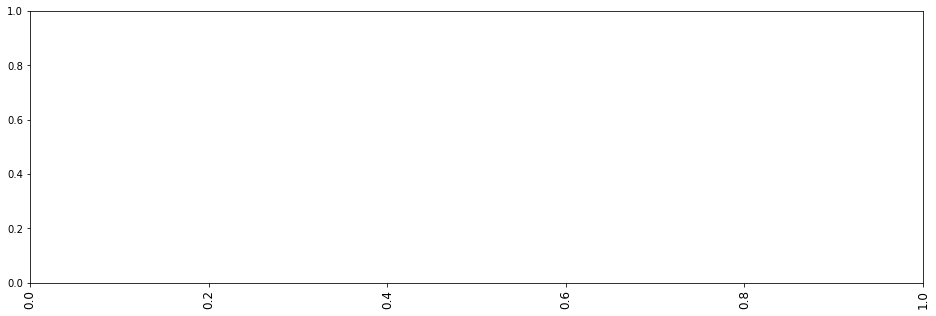

In [25]:
# sorting stations by highest total trips (started and ended trips)

fig, ax = plt.subplots(figsize=[16,5])
plt.setp(ax.xaxis.get_majorticklabels(),rotation=90,fontsize=12)
ax.bar(total_trips["station_name"].iloc[:50], total_trips["trips"].iloc[:50], color = "blue")
color = "blue"

NameError: name 'total_trips' is not defined

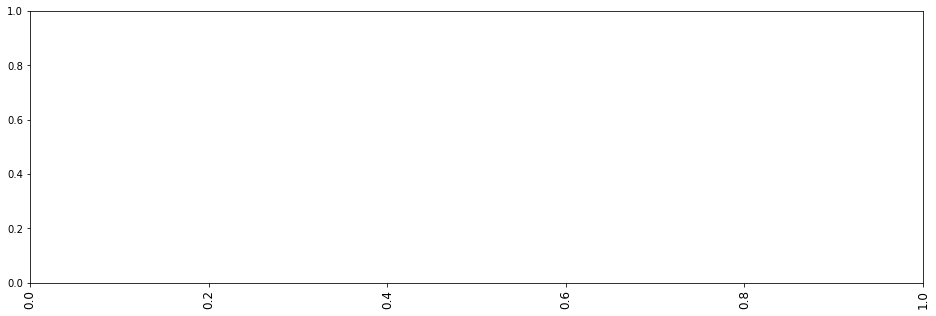

In [26]:
# sorting stations by least total trips (started and ended trips)

fig, ax = plt.subplots(figsize=[16,5])
plt.setp(ax.xaxis.get_majorticklabels(),rotation=90,fontsize=12)
ax.bar(total_trips["station_name"].iloc[-50:], total_trips["trips"].iloc[-50:], color = "violet")

In [38]:
#Getting the total amount of the different user types
user_types_total = pd.DataFrame(chicago_set["user_type"].value_counts())
user_types_total = user_types_total.rename(columns = {'user_type':'amount'})

user_types_total

,amount
Subscriber,2913917
Customer,670865


In [41]:
#plt.hist(chicago_set["user_type"])

In [44]:
a = dt.timedelta(minutes=30)
#amount of Subscribers > 30 min
subscriber_higher30 = chicago_set[(chicago_set["user_type"] == "Subscriber") & (chicago_set["duration"] > a)]
print("Subscriber > 30 minutes:", len(subscriber_higher30))

#amount of monthly passes < 30 min
subscriber_lower30 = chicago_set[(chicago_set["user_type"] == "Subscriber") & (chicago_set["duration"] <= a)]
print("Subscriber <= 30 minutes:", len(subscriber_lower30))


#amount of Walk-ups > 30 min
customer_higher30 = chicago_set[(chicago_set["user_type"] == "Customer") & (chicago_set["duration"] > a)]
print("Customer > 30 minutes:", len(customer_higher30))

#amount of Walk-ups < 30 min
customer_lower30 = chicago_set[(chicago_set["user_type"] == "Customer-up") & (chicago_set["duration"] <= a)]
print("Customer <= 30 minutes:", len(customer_lower30))

print("Customers drive more than 2 times over 30 minutes then subscribers. Mentionably is that no custumer driver used the bike less then 30 min, while most subscriber drive under 30 minutes")

Subscriber > 30 minutes: 141669
Subscriber <= 30 minutes: 2772248
Customer > 30 minutes: 309212
Customer <= 30 minutes: 0
Customers drive more than 2 times over 30 minutes then subscribers. Mentionably is that no custumer driver used the bike less then 30 min, while most subscriber drive under 30 minutes


## Demand per hour

In [49]:
# Getting the demand per hour to provide our KPI's with and look for trends

hour_demand = pd.DataFrame({'amount': chicago_set.groupby(by=[chicago_set['start_time'].apply(lambda x: x.date()),
                                                    chicago_set['start_time'].apply(lambda x: x.hour)]).size()})



hour_demand.reset_index(level=0, inplace=True)

hour_demand = hour_demand.rename(columns = {'start_time':'date'})

hour_demand.reset_index(inplace=True)

hour_demand = hour_demand.rename(columns = {'start_time':'hour'})

hour_demand['Fleet size']= fleet_size

hour_demand['user types'] = chicago_set['user_type']

hour_demand

,hour,date,amount,Fleet size,user types
0,0,2018-01-01,7,6133,Subscriber
1,1,2018-01-01,14,6133,Subscriber
2,2,2018-01-01,10,6133,Customer
3,3,2018-01-01,2,6133,Subscriber
4,4,2018-01-01,2,6133,Subscriber
...,...,...,...,...,...
8739,19,2018-12-31,41,6133,Subscriber
8740,20,2018-12-31,28,6133,Subscriber
8741,21,2018-12-31,22,6133,Subscriber
8742,22,2018-12-31,25,6133,Subscriber


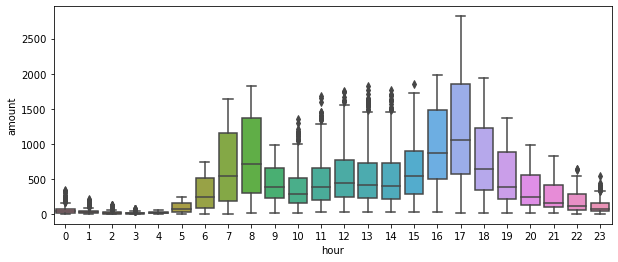

The plot shows us that it's best to charge and maintain the bikes between 22pm and 6am, when demand is at its lowest


In [50]:
#Demand per hour overall
fig,ax = plt.subplots(figsize=(10,4))

sns.boxplot(x=hour_demand["hour"], y=hour_demand["amount"], ax=ax)
plt.show()

print("The plot shows us that it's best to charge and maintain the bikes between 22pm and 6am, when demand is at its lowest")

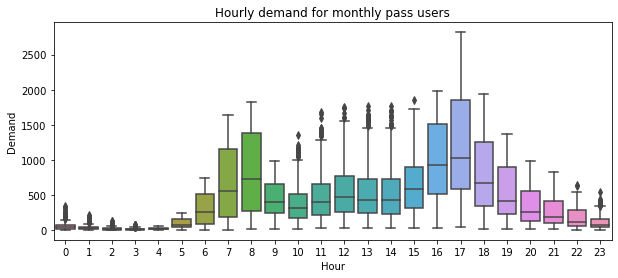

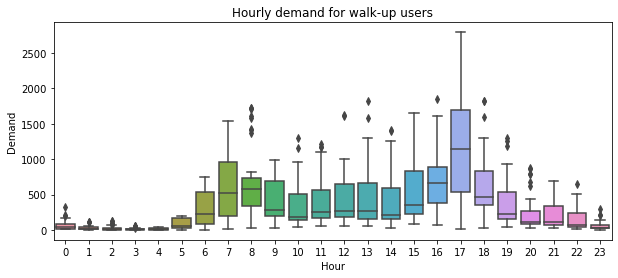

In [52]:
#Demand per hour for monthly pass users 
fig,ax = plt.subplots(figsize=(10,4))

hour_demand_mp = hour_demand[(hour_demand["user types"] == "Subscriber")]

sns.boxplot(x=hour_demand_mp["hour"], y=(hour_demand_mp["amount"]))

ax.set_xlabel("Hour")
ax.set_ylabel("Demand")
ax.set_title("Hourly demand for monthly pass users")

plt.show()

#Demand per hour for walk up users 
fig,ax = plt.subplots(figsize=(10,4))

hour_demand_wu = hour_demand[(hour_demand["user types"] == "Customer")]

sns.boxplot(x=hour_demand_wu["hour"], y=(hour_demand_wu["amount"]))

ax.set_xlabel("Hour")
ax.set_ylabel("Demand")
ax.set_title("Hourly demand for walk-up users")

plt.show()

## Utilization

In [54]:
# Calculating the utilization of the fleet
df_new = hour_demand.loc[:,"amount"].div(hour_demand["Fleet size"], axis=0)

In [55]:
# Creating new row for the fleet utilization
hour_demand['Fleet utilization']= df_new

hour_demand

,hour,date,amount,Fleet size,user types,Fleet utilization
0,0,2018-01-01,7,6133,Subscriber,0.001141
1,1,2018-01-01,14,6133,Subscriber,0.002283
2,2,2018-01-01,10,6133,Customer,0.001631
3,3,2018-01-01,2,6133,Subscriber,0.000326
4,4,2018-01-01,2,6133,Subscriber,0.000326
...,...,...,...,...,...,...
8739,19,2018-12-31,41,6133,Subscriber,0.006685
8740,20,2018-12-31,28,6133,Subscriber,0.004565
8741,21,2018-12-31,22,6133,Subscriber,0.003587
8742,22,2018-12-31,25,6133,Subscriber,0.004076


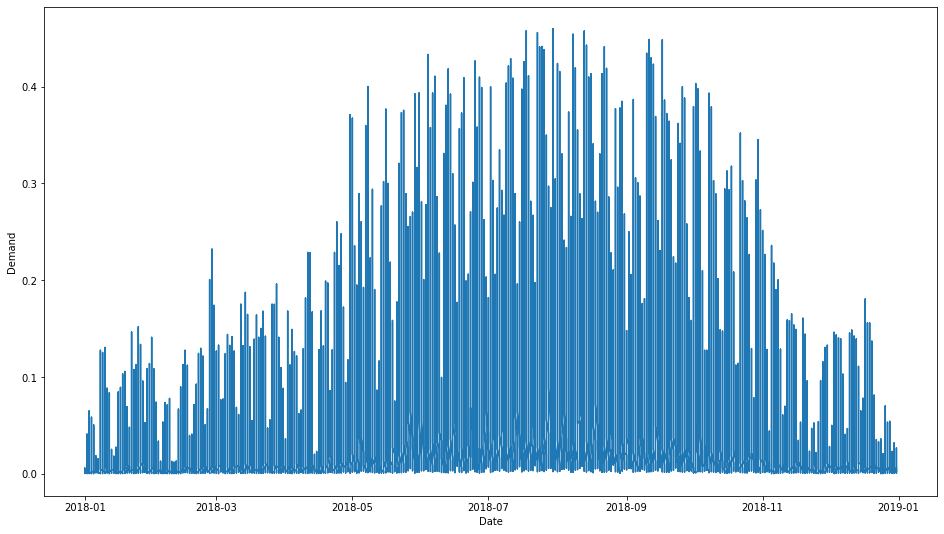

The fleet is almost never utilized for more than 5% over a day


In [56]:
fig, ax = plt.subplots(figsize = (16,9))

# Plotting the utilization data
ax.plot(hour_demand["date"],hour_demand[["Fleet utilization"]])
ax.set_xlabel("Date")
ax.set_ylabel("Demand")
plt.show()
print("The fleet is almost never utilized for more than 5% over a day")

##  Average duration

In [57]:
def get_total_hours (td):
    return (int)(td.total_seconds() / 3600)

def get_total_minute (td):
    return (int)(td.total_seconds() / 60)

In [61]:
chicago_set["minutes"] = chicago_set["duration"].apply(lambda x:int(x.total_seconds() / 60))
chicago_set

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,duration,minutes
0,2018-04-01 00:04:44,2018-04-01 00:13:03,22,171,May St & Taylor St,May St & Cullerton St,3819,Subscriber,0 days 00:08:19,8
1,2018-04-01 00:06:42,2018-04-01 00:27:07,157,190,Lake Shore Dr & Wellington Ave,Southport Ave & Wrightwood Ave,5000,Subscriber,0 days 00:20:25,20
2,2018-04-01 00:07:19,2018-04-01 00:23:19,106,106,State St & Pearson St,State St & Pearson St,5165,Customer,0 days 00:16:00,16
3,2018-04-01 00:07:33,2018-04-01 00:14:47,241,171,Morgan St & Polk St,May St & Cullerton St,3851,Subscriber,0 days 00:07:14,7
4,2018-04-01 00:10:23,2018-04-01 00:22:12,228,219,Damen Ave & Melrose Ave,Damen Ave & Cortland St,5065,Subscriber,0 days 00:11:49,11
...,...,...,...,...,...,...,...,...,...,...
3584784,2018-03-31 23:46:34,2018-04-01 00:05:24,158,260,Milwaukee Ave & Wabansia Ave,Kedzie Ave & Milwaukee Ave,1935,Subscriber,0 days 00:18:50,18
3584785,2018-03-31 23:47:43,2018-03-31 23:52:05,299,229,Halsted St & Roscoe St,Southport Ave & Roscoe St,5852,Subscriber,0 days 00:04:22,4
3584786,2018-03-31 23:50:18,2018-03-31 23:57:38,327,226,Sheffield Ave & Webster Ave,Racine Ave & Belmont Ave,4414,Subscriber,0 days 00:07:20,7
3584787,2018-03-31 23:52:26,2018-04-01 00:07:13,265,426,Cottage Grove Ave & Oakwood Blvd,Ellis Ave & 60th St,6448,Subscriber,0 days 00:14:47,14


In [62]:
# Calculate the average biking time
time_zero = pd.to_datetime('2019-01-01 00:00:00')

df1 = chicago_set[['start_time', 'minutes']]
df1 = df1.groupby(df1['start_time'].apply(lambda x: get_total_hours(x-time_zero))).sum()
df1.reset_index(level=0, inplace=True)
df1['amount'] = hour_demand["amount"]
df1['Average biking time'] = df1.loc[:,"minutes"].div(df1['amount'], axis = 0)


df1

,start_time,minutes,amount,Average biking time
0,-8759,83,7,11.857143
1,-8758,116,14,8.285714
2,-8757,99,10,9.900000
3,-8756,20,2,10.000000
4,-8755,9,2,4.500000
...,...,...,...,...
8739,-4,688,41,16.780488
8740,-3,512,28,18.285714
8741,-2,277,22,12.590909
8742,-1,308,25,12.320000
